# <center> Replication of Simulations from Miller (1996 JEDC) </center>
### <center> Code by Yaroslav Rosokha </center>

In [13]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import time
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [23]:
class population():
    
    def __init__(self,N,alpha):
        self.N=N #Number of agents in the population
        self.alpha=alpha # Fraction of mistakes (in the paper it takes on 0.00, 0.01, and 0.05)
        self.Gen=np.random.randint(low=0,high=2,size=(N,148)) #Generate population of N agents using numpy. Each agent is represented by 148 bits.
        self.newGen=np.random.randint(low=0,high=2,size=(N,148)) #Allocate space for next generation (Needed for transition from one generation to the next)
        self.G=[[3,0],[5,1]] #Game payoffs
        self.P=np.zeros((N,N)) #Allocate space for payoffs when playing each agent against each other.
        
    def getAutomatInfo(self):
        #Convert generation to automatons (starting state, states, transitions)
        self.S=np.array([''.join([str(i) for i in x]) for x in self.Gen]) #Obtain a string of 0s and 1s with .join() and list comprehension
        self.start=[int(x[0:4],2) for x in self.S] #Extract starting state and covert to integer
        self.states=[[int(x[4+n*9]) for n in range(16)] for x in self.S] #Extract each of the states and convert to integers
        self.trans={0:[[int(x[(5+n*9):(5+(n)*9+4)],2) for n in range(16)] for x in self.S],\
               1:[[int(x[(9+n*9):(9+(n)*9+4)],2) for n in range(16)] for x in self.S]} #Extract transition to after the other plays 0s or 1s

    def playGame(self,ind1,ind2):
        p1,p2=0,0 #initialize payoffs
        s1,s2=self.start[ind1],self.start[ind2] #start in the starting states   
        for i in range(150): #simulate for 150 periods
            a1=self.states[ind1][s1] #get action 1
            if np.random.random()<self.alpha:a1=1-a1#noisy decision
            a2=self.states[ind2][s2] #get action 2
            if np.random.random()<self.alpha:a2=1-a2#noisy decision
            p1+=self.G[a1][a2] #get payoff for agent 1
            p2+=self.G[a2][a1] #get payoff for agent 2
            s1,s2=self.trans[a2][ind1][s1],self.trans[a1][ind2][s2] #get next state
        return [p1,p2] #return total payoffs
    
    def evalFitness(self):
        for i in range(self.N):
            for j in range(i,self.N):
                self.P[i,j],self.P[j,i]=self.playGame(i,j)
        return [self.P.sum(axis=1),self.P.sum()/(N*N*150)] #Return an array of payoffs as well as average payoff per period
    
    def evolve(self,nGen):
        results=np.zeros(nGen)
        for t in range(nGen):
            self.getAutomatInfo()
            fit,results[t]=self.evalFitness()
        
            #Copy top 20 parents
            top20=fit.argsort()[-20:][::-1]
            self.newGen[range(20)]=self.Gen[top20]
            
            #Normalize (see footnote 7 in the paper)
            fit20=fit[top20]
            if fit20.std()!=0:
                fit20=(fit20-fit20.mean())/fit20.std()+2
                fit20[fit20<0]=0

            #Remaining 10 are children
            parents=np.random.choice(range(20),p=fit20/fit20.sum(),size=(5,2)) #Get parents based on fitness criteria
            for i in range(5):
                p1,p2=self.Gen[parents[i,0]],self.Gen[parents[i,1]] #Get parents arrays
                cPoint=1+np.random.randint(147) #148-1 so that crossover occurs within the string
                ch1=np.concatenate([p1[0:cPoint],p2[cPoint:148]]) #Child 1 from crossover
                ch2=np.concatenate([p2[0:cPoint],p1[cPoint:148]]) #Child 2 from crossover
                mut1=np.random.choice([0,1],p=[.995,.005],size=148) #Get mutation array 1
                mut2=np.random.choice([0,1],p=[.995,.005],size=148) #Get mutation array 2
                ch1[mut1==1]=1-ch1[mut1==1] #flip 1 into 0 and 0 into 1 for those that have mut1 1
                ch2[mut2==1]=1-ch2[mut2==1] #flip 1 into 0 and 0 into 1 for those that have mut2 1
                self.newGen[20+i*2],self.newGen[20+i*2+1]=ch1,ch2 #assign the two childred to the new generation
            
            self.Gen=copy.deepcopy(self.newGen) #save newGen as Gen
                
        return results

In [24]:
#Run simulation
N=30 #Number of players
nSim=50 #Number of simulations
nGen=50 #Number of generations
noise=[0,.01,.05]
t1=time.time()
results=[[population(N,a).evolve(nGen) for i in range(nSim)] for a in noise]
t2=time.time()
print(nSim,"x",len(noise)," simulations of population of size ",N," over ",nGen," generations took ",t2-t1," seconds.")

50 x 3  simulations of population of size  30  over  50  generations took  503.637000084  seconds.


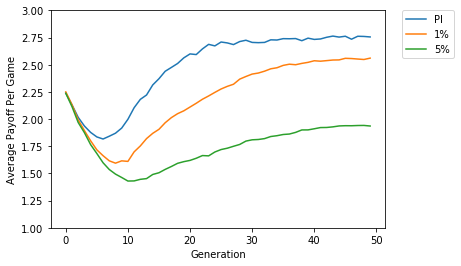

In [25]:
#Plot results
labels=['PI','1%','5%']
for i in range(3):
    plt.plot(range(nGen),np.array(results[i]).mean(axis=0),label=labels[i])
plt.xlabel('Generation')
plt.ylabel('Average Payoff Per Game')
plt.ylim((1,3))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()